# 집값 예측
- 전략
    - 지역구분 $\rightarrow$ 재건축 여부  $\rightarrow$ 크기, 방갯수 $\rightarrow$ 경치
    - grade는 어떻게 쓸지 고민
    - 재건축, 혹은 건축 이후 40년 지난 것들 분류하여 땅값 계산, 40년 안지난것은 건물값고려, 감가상각 고려.

- Data fields
    - ID : 집을 구분하는 번호
    - date : 집을 구매한 날짜
    - price : 집의 가격(Target variable)
    - bedrooms : 침실의 수
    - bathrooms : 침실 개수 당 화장실의 수(화장실의 수 / 침실의 수 )
    - sqft_living : 주거 공간의 평방 피트(면적)
    - sqft_lot : 부지의 평방 피트(면적)
    - floors : 집의 층 수
    - waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
    - view : 집이 얼마나 좋아 보이는지의 정도
    - condition : 집의 전반적인 상태   #건물 연식이 몇년이 지나면 가격 같음
    - grade : King County grading 시스템 기준으로 매긴 집의 등급   
    - sqft_above : 지하실을 제외한 평방 피트(면적)
    - sqft_basement : 지하실의 평방 피트(면적)   # 지하실 있는 데이터는 따로 취급?
    - yr_built : 지어진 년도
    - yr_renovated : 집을 재건축한 년도
    - zipcode : 우편번호
    - lat : 위도
    - long : 경도
    - sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)
    - sqft_lot15 : 2015년 기준 부지의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)

In [15]:
import pandas as pd
import numpy as np
import random

In [68]:
# import matplotlib as mpl
# import matplotlib.pyplot as plt
# import seaborn as sns #Visulization

In [2]:
# (데이터 수가 작아서 전처리 단계에서는 샘플 안해도 될듯)
# 이중 1000개의 데이터를 임의로 샘플 추출 합니다.  
def rd_data(data, number = 100):
    rd_idx = [random.randint(0,len(data)) for _ in range(number)]   # 0 ~ len(data) 개까지의 인덱스 중 랜덤 샘플 # 개 추출
    sample = data.iloc[rd_idx].reset_index(drop=True)  # 샘플 추출
    return sample

## 0. 데이터 불러오기 및 기본 전처리

In [1]:
house = pd.read_csv("dataset/train.csv")

In [2]:
house_test = pd.read_csv("dataset/test.csv")

In [3]:
#id 드랍
house.drop(columns= ['id'], inplace = True)
# house_test.drop(columns= ['id'], inplace = True) #정답 제출할때 필요해서 놔두기 test 데이터의 id는 놔두기

In [4]:
# 위도+경도로이루어진 새로운 아이디 부여
house['Newid'] = (round(-house['long']*1000,0)+round(house['lat']/100,6))
#house_test['Newid'] = (-house_test['long']*1000+house_test['lat']/100)

In [5]:
# date(구매시기) 데이터 줄여주기 ex) 20141013T000000 -> 20141013 ->2014.1013  (구매와 건축 시기 차이 구할 때 유용)
date_2 = [round(int(house['date'].iloc[i][:8])/10000, 4) for i in range(len(house))]
house['date'] = date_2

In [6]:
# price 정규화 0 < price < 1
house['price'] = house['price']/7.700000e+06

In [7]:
# 'Newid'가 모두 13자리로 잘 만들어졌는지. 아니면 index 출력
def test_Newid(df):
    test = []
    for i in range(len(df)):
        if len(str(df['Newid'].iloc[i]))==13:
            continue
        else:
            test.append(i)
    return test

In [8]:
#NAN 존재여부 테스트
house.isnull().sum().sum()  
# Nan 없음.

0

### #. zipcode : 삭제
- zipcode는 위치와 상관이 없다.
- 같은 zipcode를 가지는 집들 중 (위도, 경도)를 구글 지도에 찍어보면 서로 완전 다른 지역을 나타내고 있다.
- 따라서 zipcode는 무의미한 정보이다.

In [9]:
# zipcode와 (위도, 경도) 정보 조사
house[['price', 'zipcode', 'lat', 'long']].sort_values(by = ['zipcode']).reset_index(drop=True).head()

,price,zipcode,lat,long
0,0.037662,98001,47.3530,-122.294
1,0.059740,98001,47.2619,-122.271
2,0.033117,98001,47.3318,-122.277
3,0.053896,98001,47.3359,-122.257
4,0.043117,98001,47.3524,-122.285


In [10]:
#zipcode 삭제
house.drop(columns=['zipcode'], inplace=True)

# #. snspairplot

In [19]:
house.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,Newid
0,2014.1013,0.028818,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,47.5112,-122.257,1340,5650,122257.475112
1,2015.0225,0.023377,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,47.7379,-122.233,2720,8062,122233.477379
2,2015.0218,0.066234,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,47.6168,-122.045,1800,7503,122045.476168
3,2014.0627,0.033442,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,47.3097,-122.327,2238,6819,122327.473097
4,2015.0115,0.037903,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,47.4095,-122.315,1650,9711,122315.474095


In [23]:
house['price'].describe()

count    15035.000000
mean         0.070219
std          0.048250
min          0.010130
25%          0.041818
50%          0.058442
75%          0.083766
max          1.000000
Name: price, dtype: float64

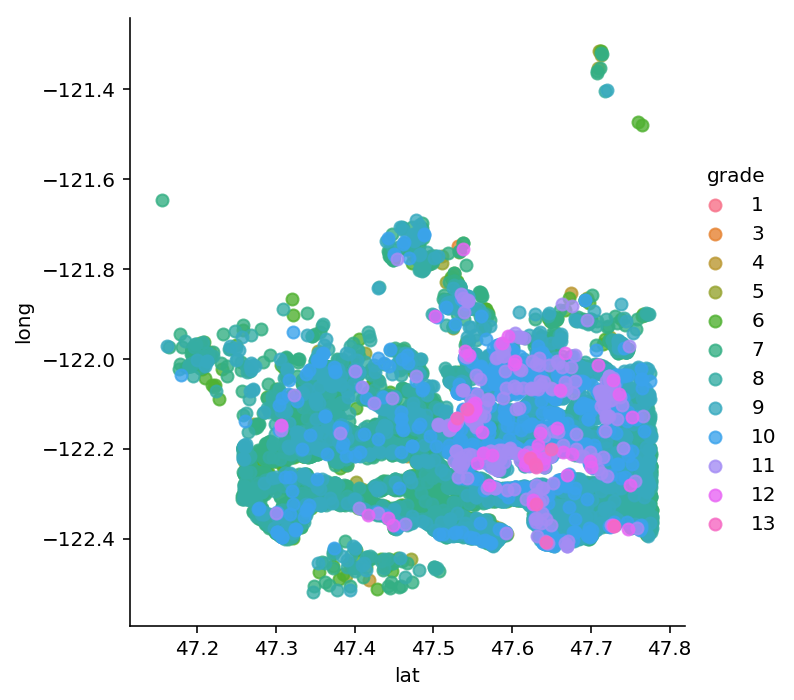

In [21]:
sns.lmplot("lat", "long", data=house,  hue='grade', fit_reg=False) 
#fit_reg : True이면 fitting graph도 나옴. hue : 어떤 것을 색으로 표현할지.
plt.show()

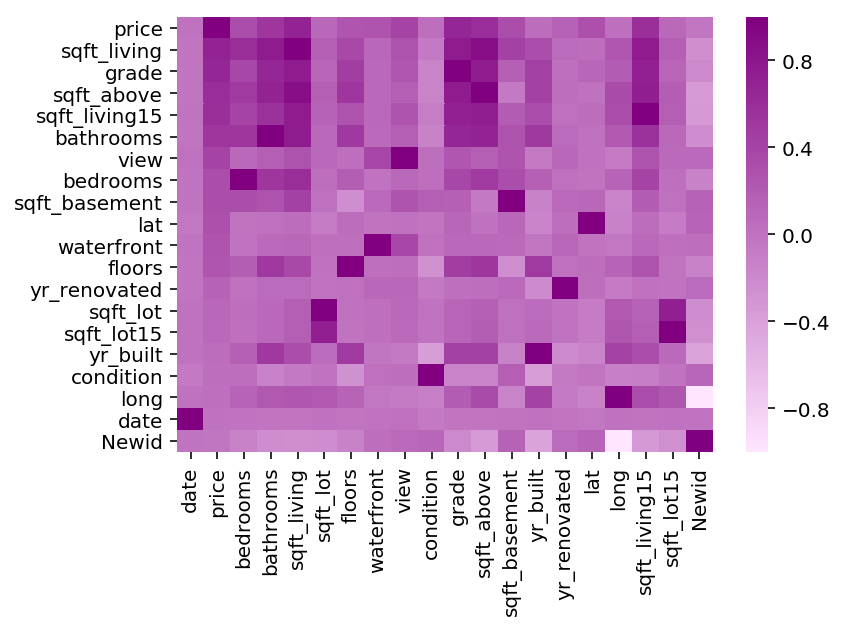

In [50]:
h_corr1 = house.corr(method='pearson').sort_values(by=['price'], ascending=False)  
# 상관계수 dataframe /  가격과 상관계수 큰 순으로 정렬

#heatmap으로 그리기
sns.heatmap(h_corr1, cmap=sns.light_palette("purple", as_cmap=True))#, annot=True, fmt=".2f")
plt.show()

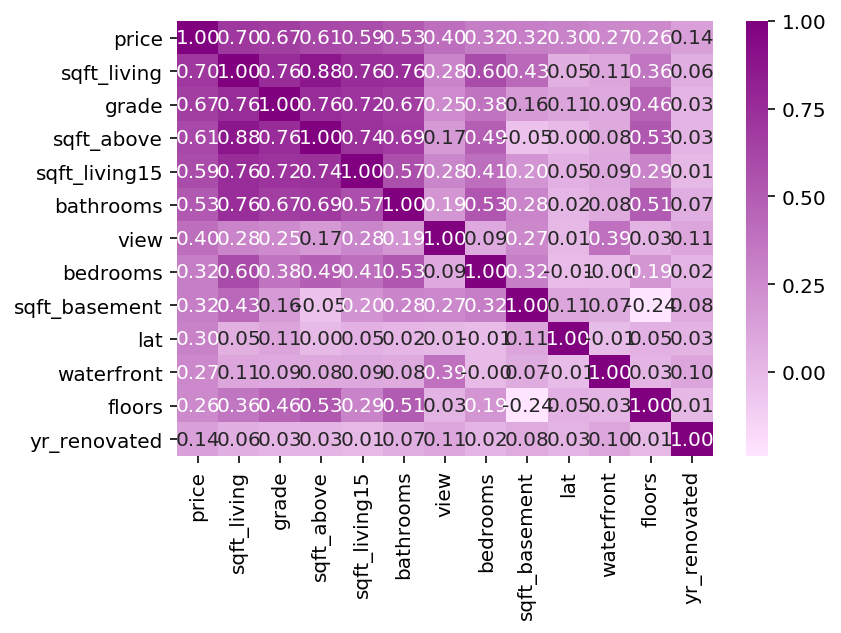

In [54]:
col_ls2 = ['price', 'sqft_living', 'grade', 'sqft_above', 'sqft_living15', 'bathrooms', 'view', 'bedrooms', \
          'sqft_basement', 'lat', 'waterfront', 'floors', 'yr_renovated'] #가격과 상관계수 낮은 것 제외하고 남은것
h_corr2 = house[col_ls2].corr(method='pearson').sort_values(by=['price'], ascending=False)  
# 상관계수 dataframe,  가격과 상관계수 큰 순으로 정렬

#heatmap으로 그리기
sns.heatmap(h_corr2, cmap=sns.light_palette("purple", as_cmap=True), annot=True, fmt=".2f")
plt.show()

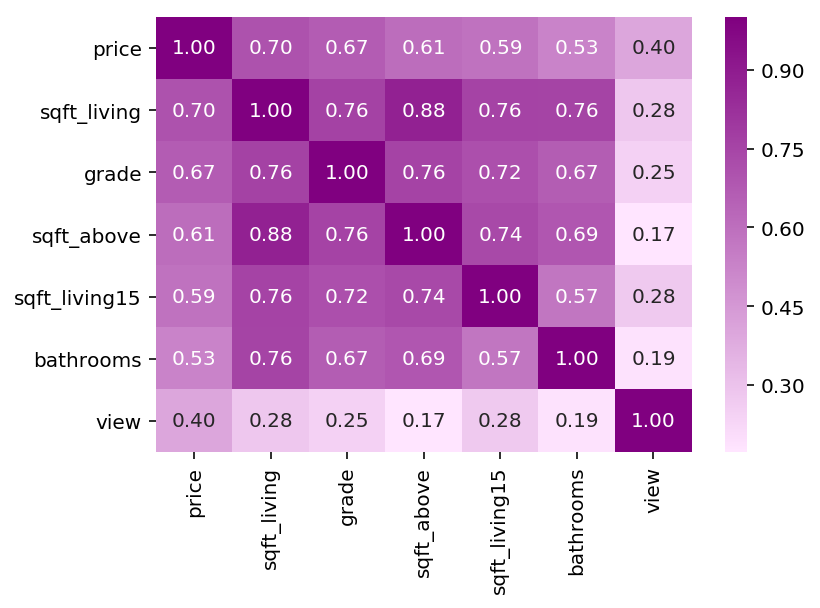

In [55]:
col_ls3 = ['price', 'sqft_living', 'grade', 'sqft_above', 'sqft_living15', 'bathrooms', 'view']
#가격과 상관계수 낮은 것 제외하고 남은것
h_corr3 = house[col_ls3].corr(method='pearson').sort_values(by=['price'], ascending=False)  
# 상관계수 dataframe,  가격과 상관계수 큰 순으로 정렬

#heatmap으로 그리기
sns.heatmap(h_corr3, cmap=sns.light_palette("purple", as_cmap=True), annot=True, fmt=".2f")
plt.show()
# sqft_living 이랑 above가 많이 상관관계가 있네

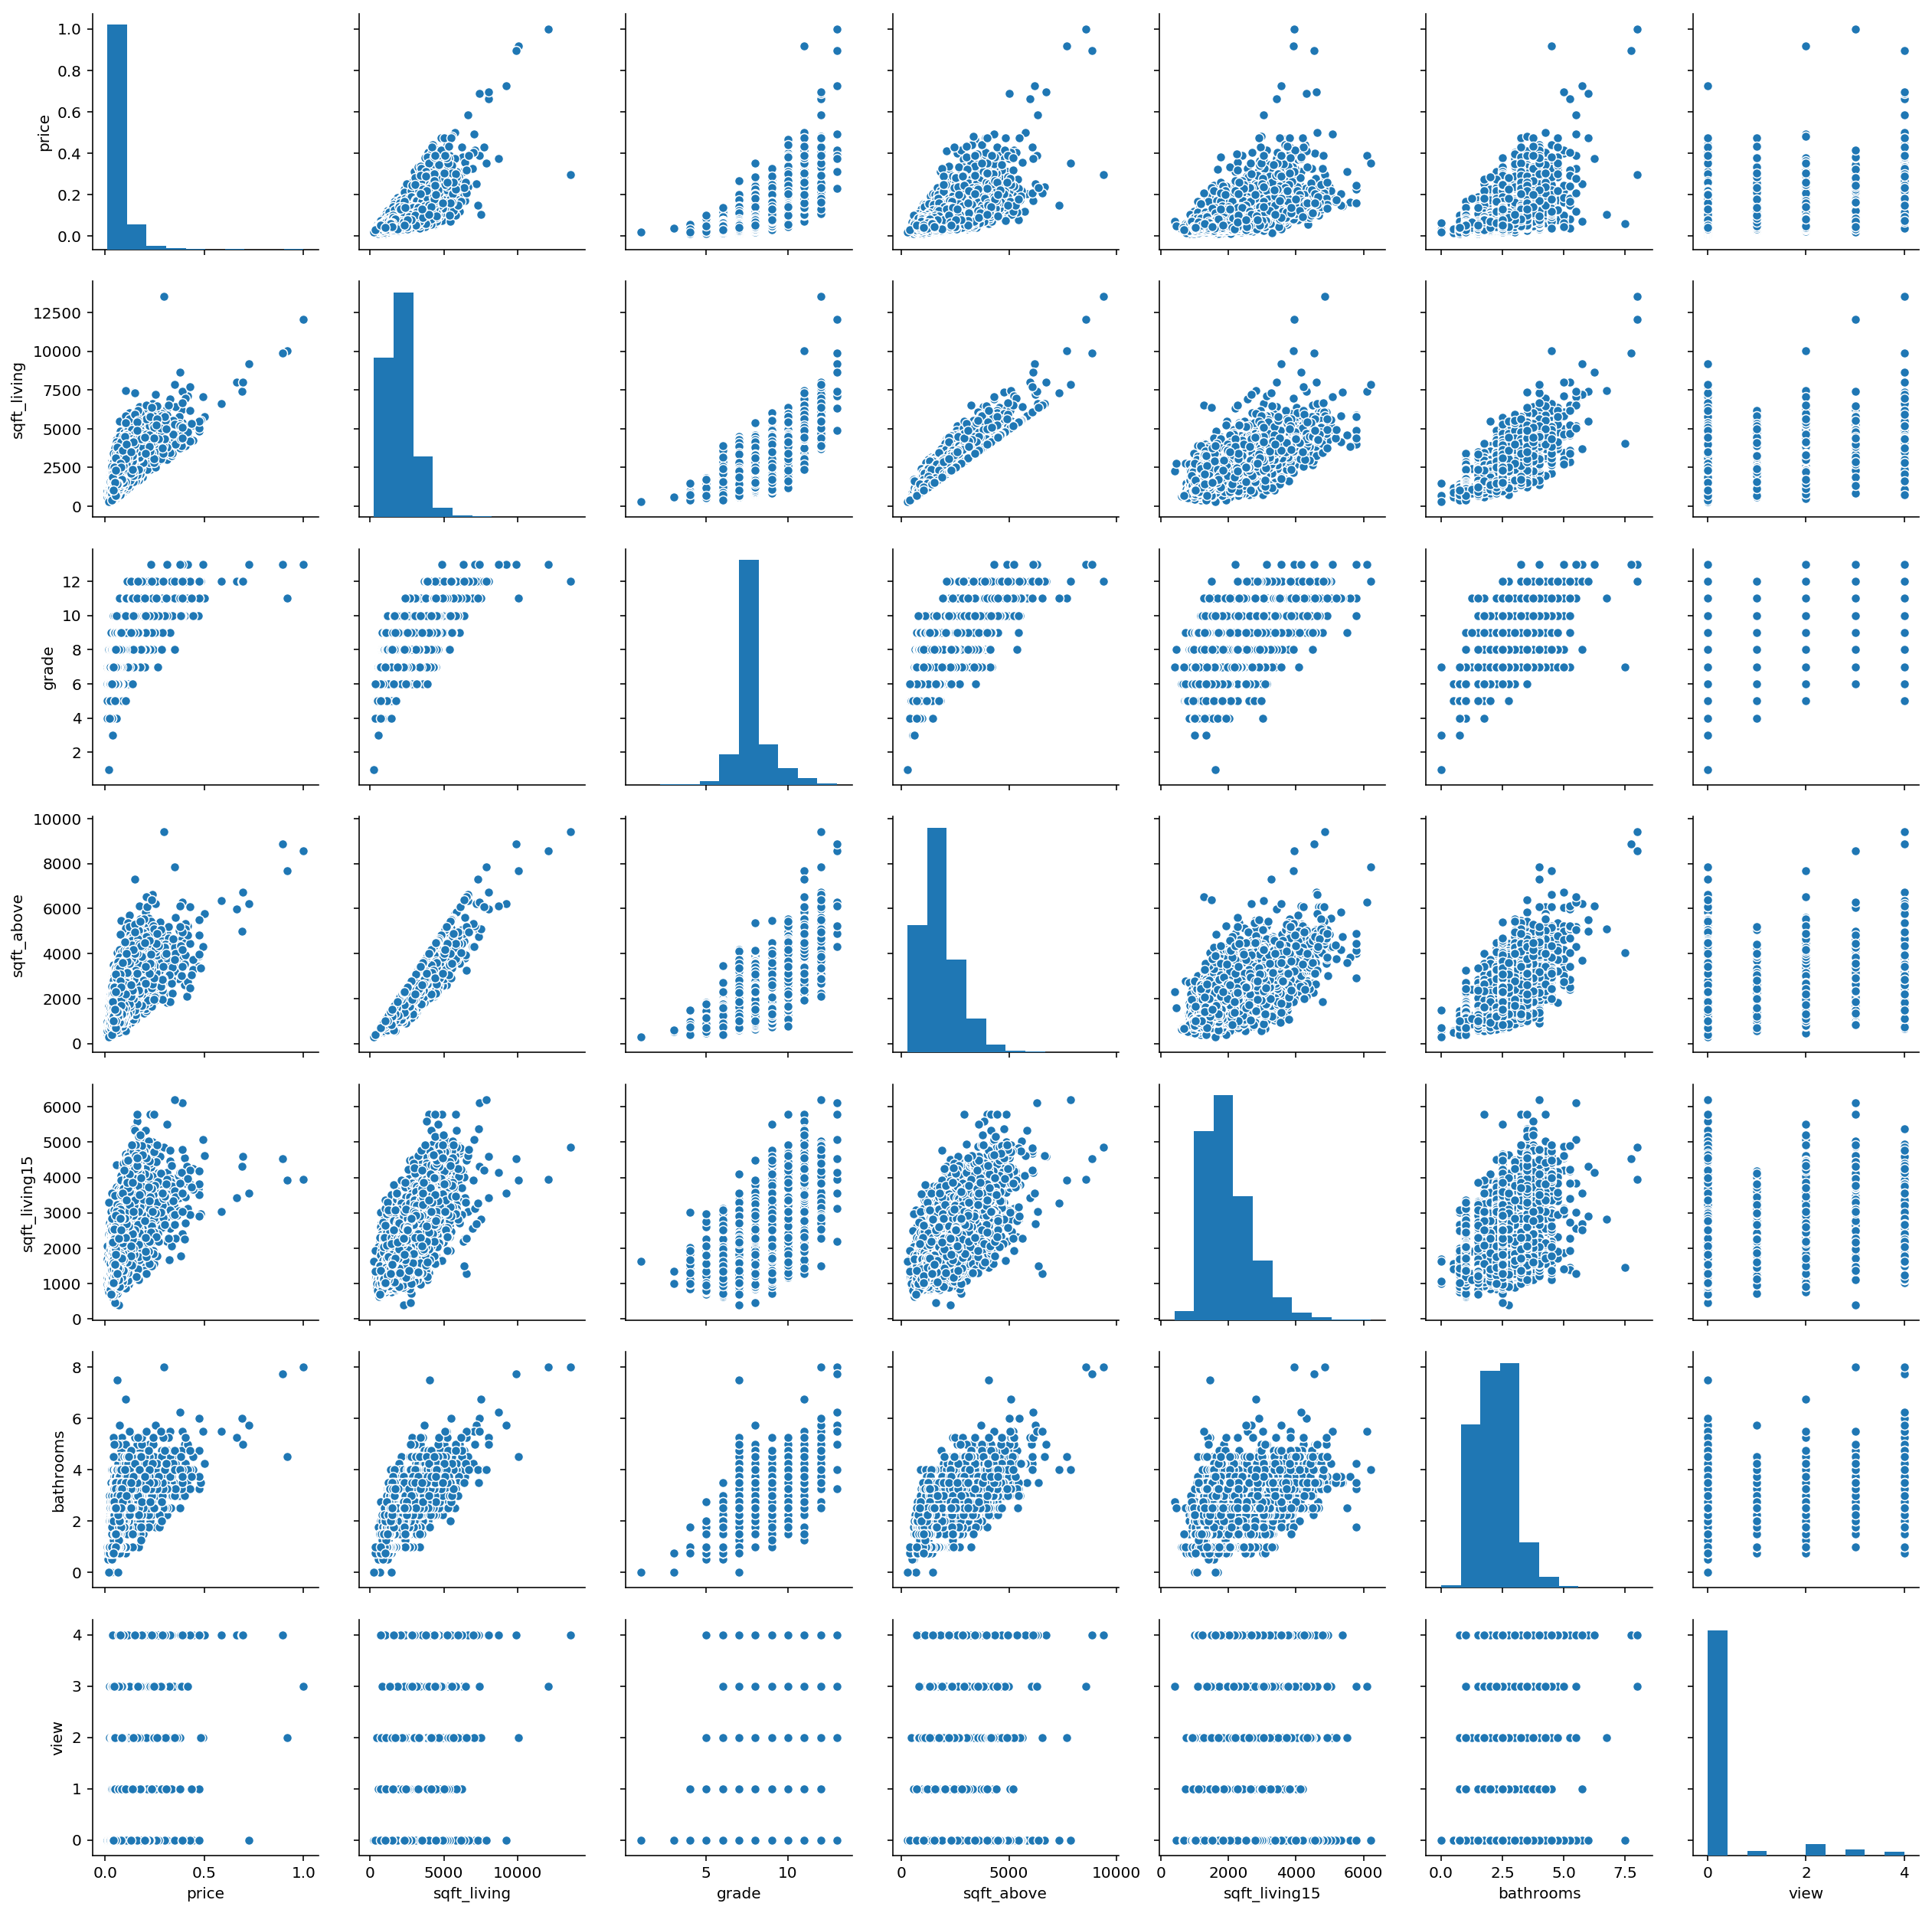

In [56]:
sns.pairplot(house[col_ls3]) #,  hue="species"
plt.show()

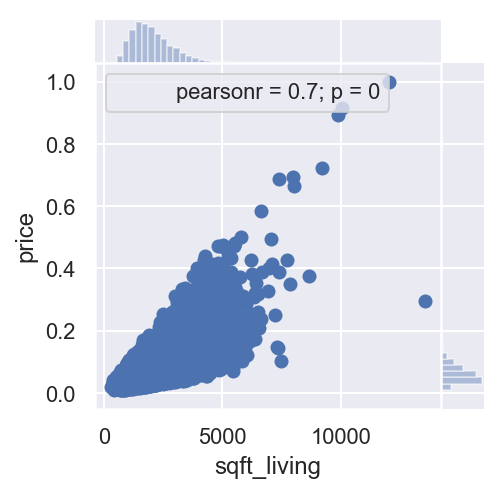

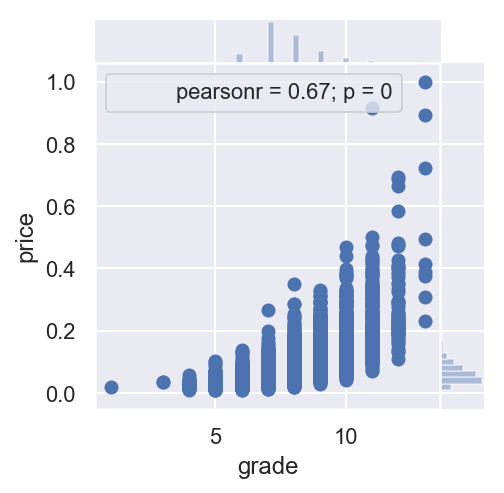

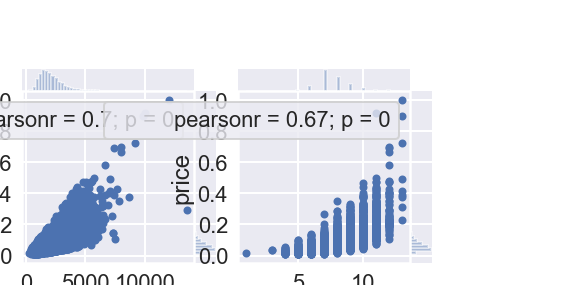

In [71]:
JG1 = sns.jointplot("sqft_living", "price", data=house).annotate(stats.pearsonr)
JG2 = sns.jointplot("grade", "price", data=house).annotate(stats.pearsonr)

#subplots migration
f = plt.figure()
for J in [JG1, JG2]:
    for A in J.fig.axes:
        f._axstack.add(f._make_key(A), A)

#subplots size adjustment
f.axes[0].set_position([0.05, 0.05, 0.4,  0.4])
f.axes[1].set_position([0.05, 0.45, 0.4,  0.05])
f.axes[2].set_position([0.45, 0.05, 0.05, 0.4])
f.axes[3].set_position([0.55, 0.05, 0.4,  0.4])
f.axes[4].set_position([0.55, 0.45, 0.4,  0.05])
f.axes[5].set_position([0.95, 0.05, 0.05, 0.4])

plt.show()

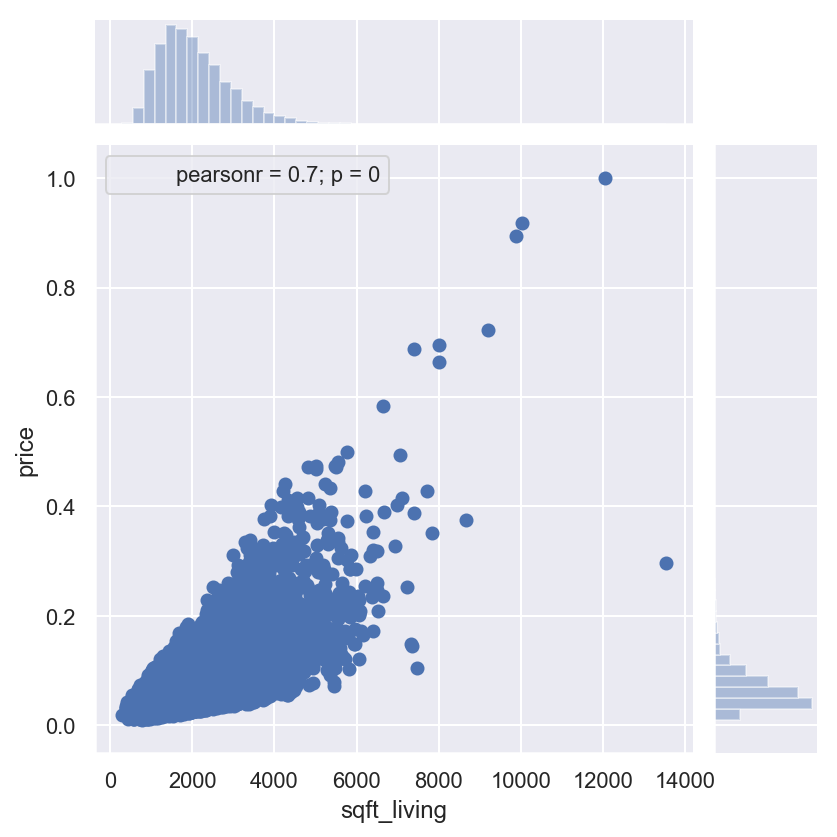

In [72]:
import scipy.stats as stats
sns.jointplot("sqft_living", "price", data=house).annotate(stats.pearsonr) #"sqft_living", "price"간의 상관관계 

plt.show()

## price를 불연속값으로 만들고서 카테고라이징 시도해보기

# #. grade에대해 조사
- grade=2 인 것이 없다
- 평균, 표준편차, 최소, 최대 
    - mean         7.660725
    - std          1.179803
    - min          1.000000
    - 25%          7.000000
    - 50%          7.000000
    - 75%          8.000000
    - max         13.000000
- house_test 에는 1등급고 3등급이 최소이다. house 에서도 1을 지우고 훈련 고고

In [24]:
# 대략 평균값이 median=7에 근접하게 잡혀있다.
house['grade'].describe()

count    15035.000000
mean         7.660725
std          1.179803
min          1.000000
25%          7.000000
50%          7.000000
75%          8.000000
max         13.000000
Name: grade, dtype: float64

In [30]:
house_test['grade'].describe()

count    6468.000000
mean        7.655535
std         1.161900
min         3.000000
25%         7.000000
50%         7.000000
75%         8.000000
max        13.000000
Name: grade, dtype: float64

In [17]:
house.groupby('grade')['price'].aggregate(['mean', 'max', 'min'])

,mean,max,min
grade,,,
1,0.018442,0.018442,0.018442
3,0.035195,0.036364,0.034026
4,0.027239,0.056494,0.010390
5,0.032606,0.103247,0.010130
6,0.038981,0.136623,0.010909
7,0.052147,0.266234,0.011688
8,0.070431,0.350649,0.018182
9,0.100452,0.330649,0.029870
10,0.137985,0.467532,0.041039


- SOLUTION
- grade				mean	max	min
- 3	0.009740	0.009740	0.009740
- 4	0.030152	0.046104	0.016883
- 5	0.030781	0.071429	0.010714
- 6	0.039626	0.155844	0.010649
- 7	0.052432	0.214286	0.014935
- 8	0.070646	0.398701	0.021818
- 9	0.100321	0.350649	0.033377
- 10	0.141908	0.463247	0.049351
- 11	0.186029	0.444000	0.054545
- 12	0.280877	0.606234	0.116883
- 13	0.358247	0.493506	0.303896
- 
-	TRAIN
- grade			mean	max	min
- 3	0.035195	0.036364	0.034026
- 4	0.027239	0.056494	0.010390
- 5	0.032606	0.103247	0.010130
- 6	0.038981	0.136623	0.010909
- 7	0.052147	0.266234	0.011688
- 8	0.070431	0.350649	0.018182
- 9	0.100452	0.330649	0.029870
- 10	0.137985	0.467532	0.041039
- 11	0.197722	0.917208	0.071429
- 12	0.288382	0.694805	0.108442
- 13	0.536667	1.000000	0.231169
- 
- 13이랑 3,4 쪽이 예측이 어려울듯. 아마 샘플이 적엇 그런거라 생각됨
- 일단 5~12등급까지는 grade로 예측. 다른 것들은 다른 방법 강구



# #. grade 다음으로 가격을 결정하는 요인은?

In [46]:
house[house['grade']==5].sort_values(by=['price'], ascending = True).tail()
#  이상치 없음.

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,Newid
10474,2015.0501,0.073052,2,1.0,1170,2800,1.5,0,0,4,5,1170,0,1905,0,47.6574,-122.345,1660,4996,122345.476574
10729,2015.0114,0.085455,2,1.0,1010,14244,1.0,1,4,1,5,1010,0,1926,0,47.5476,-122.399,1820,15792,122399.475476
9824,2015.0327,0.092857,2,1.0,1000,3513,1.0,0,4,4,5,1000,0,1914,0,47.5935,-122.390,1930,4920,122390.475935
12313,2014.1125,0.100649,3,2.0,1160,13747,1.0,0,0,5,5,580,580,1931,0,47.5850,-122.051,2961,16320,122051.475850
509,2015.0407,0.103247,2,1.0,1380,5000,1.5,0,2,3,5,1380,0,1905,0,47.5708,-122.359,1500,5000,122359.475708


In [41]:
house[house['grade']==11].sort_values(by=['price'], ascending = True).head()
# 가격 : 0.917208 이상치 (Newid = 122214.476500)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,Newid
12472,2014.0924,0.071429,4,3.00,4180,35169,2.0,0,0,3,11,4180,0,1986,1998,47.4000,-122.027,3010,35190,122027.474000
943,2014.0523,0.072208,5,2.50,3840,16905,2.0,0,0,3,11,3840,0,1991,0,47.2996,-122.342,3270,12133,122342.472996
12308,2014.1219,0.082208,5,2.75,3630,30570,2.0,0,0,3,11,3630,0,2000,0,47.4243,-122.097,3620,41965,122097.474243
9849,2014.0611,0.085390,4,2.75,4140,24190,2.0,0,0,3,11,4140,0,2002,0,47.3062,-122.150,3950,24190,122150.473062
4536,2014.0811,0.094156,3,2.50,3410,41022,2.0,0,0,3,11,3410,0,1990,0,47.3228,-122.080,2150,21429,122080.473228


In [38]:
house[house['Newid']==]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,Newid
2775,2014.0611,0.917208,5,4.5,10040,37325,2.0,1,2,3,11,7680,2360,1940,2001,47.65,-122.214,3930,25449,122214.4765


In [42]:
house[house['grade']==13].sort_values(by=['price'], ascending = True)
# 가격 : 0.917208 이상치 (Newid = 122214.476500)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,Newid
3867,2014.1010,0.231169,4,3.25,4890,13402,2.0,0,0,3,13,4890,0,2004,0,47.5303,-122.131,5790,13539,122131.475303
4266,2014.1120,0.309740,4,4.00,6330,13296,2.0,0,2,3,13,4900,1430,2000,0,47.6488,-122.201,2200,9196,122201.476488
10152,2014.0611,0.375065,5,6.25,8670,64033,2.0,0,4,3,13,6120,2550,1965,2003,47.7295,-122.372,4140,81021,122372.477295
7246,2014.1212,0.387403,5,5.50,7400,18898,2.0,0,3,3,13,6290,1110,2001,0,47.5431,-122.112,6110,26442,122112.475431
5560,2014.0923,0.415584,6,5.00,7100,18200,2.5,0,0,3,13,5240,1860,1933,2002,47.6427,-122.408,3130,6477,122408.476427
4957,2014.0701,0.493506,5,5.50,7050,42840,1.0,0,2,4,13,4320,2730,1978,0,47.6229,-122.220,5070,20570,122220.476229
3134,2014.0804,0.723377,5,5.75,9200,35069,2.0,0,0,3,13,6200,3000,2001,0,47.6289,-122.233,3560,24345,122233.476289
6469,2014.0919,0.894156,6,7.75,9890,31374,2.0,0,4,3,13,8860,1030,2001,0,47.6305,-122.240,4540,42730,122240.476305
5108,2014.1013,1.000000,6,8.00,12050,27600,2.5,0,3,4,13,8570,3480,1910,1987,47.6298,-122.323,3940,8800,122323.476298


In [43]:
house.groupby("grade").size().reset_index(name="counts")

,grade,counts
0,1,1
1,3,2
2,4,23
3,5,174
4,6,1406
5,7,6228
6,8,4207
7,9,1855
8,10,781
9,11,288


---

In [133]:
# 가격, 아이디만 추출
house1 = house[['date', 'price', 'sqft_living', 'Newid']]

In [134]:
# Newid가 겹치는 것이 있는지 확인
print(len(house1))
house1.groupby("Newid").size().reset_index(name="counts") .tail()
    #아 겹치는 데이터가있네...

15035


,Newid,counts
14731,122509.474444,1
14732,122511.474285,1
14733,122514.473782,1
14734,122515.473942,1
14735,122519.473477,1


In [144]:
# house_ref에서 house에 있는 데이터만 골라내기위한 Data Frame
# : 위도 경도로 생성된 아이디 +  날짜가 일치하는 데이터를 house_ref로부터 가져오는 함수.
# h_result = pd.DataFrame(columns =['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', \
#                        'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',\
#                        'sqft_living15', 'sqft_lot15', 'Newid'])
def h_result_from_ref(house):
    h_result = pd.DataFrame(columns =['date', 'price', 'sqft_living', 'Newid'])   #데이터 프레임 생성
    for i in range(len(house)):
        temp = house_ref1[house_ref1['Newid'] == house['Newid'].iloc[i]]  #i 번째 아이디가 일치하는지 확인
        if len(temp) != 1 and len(temp) > 0:      #일치하는게 여러개일 경우 # 
            temp = temp[temp['date'] == house['date'].iloc[i]]  # 그 중 날짜 정보까지 일치하는것을 찾는다.
            if len(temp) !=1:
                temp = temp[temp['sqft_living'] == house['sqft_living'].iloc[i]]  # 그 중 날짜 정보까지 일치하는것을 찾는다.
                if len(temp) !=1:
                    temp = temp.iloc[random.randint(0,len(temp)-1)]                
                    h_result = h_result.append(temp)
                else:
                    h_result = h_result.append(temp)
            else:
                h_result = h_result.append(temp)
        elif len(temp) == 1:   #일치하는게 하나일 경우
            h_result = h_result.append(temp)   # 그냥 포함시킨다.
        else:  # house_ref에서 정보 못찾으면 error와 함께 인덱스 정보 출력
            print('error : {}번째 index'.format(i))
  #          h_result = h_result.append(temp)    
    h_result.reset_index(drop=True, inplace=True)
    return h_result

In [149]:
# 크로스 체크 함수
def cross_check(house):
    test = (house['price'] - h_result_from_ref(house)['price']).sum()  #일치 여부 확인. 0이면 정확히 일치한다.
    return test

In [147]:
h_rd = rd_data(house1, 1000)

In [148]:
h_result_from_ref(h_rd).tail()

,date,price,sqft_living,Newid
995,20140820T000000,300000.0,2360,122245.475044
996,20150423T000000,333760.0,1300,122113.476937
997,20141215T000000,850000.0,2700,122024.477187
998,20140916T000000,379000.0,930,122372.476971
999,20140908T000000,285000.0,1890,122041.473613


In [150]:
cross_check(h_rd)

0.0

In [92]:
pd.DataFrame(h_result_from_ref(h_rd).iloc[40]).T

,date,price,Newid
40,20140821T000000,440000,122033


In [93]:
pd.DataFrame(h_rd.iloc[40]).T

,date,price,Newid
40,20140821T000000,475000,122033


In [81]:
(h_rd['price'] - h_result_from_ref(h_rd)['price']).head(43)

0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
5          0.0
6          0.0
7          0.0
8          0.0
9          0.0
10         0.0
11         0.0
12         0.0
13         0.0
14         0.0
15         0.0
16         0.0
17         0.0
18         0.0
19         0.0
20         0.0
21         0.0
22         0.0
23         0.0
24         0.0
25         0.0
26         0.0
27         0.0
28         0.0
29         0.0
30         0.0
31         0.0
32         0.0
33         0.0
34         0.0
35         0.0
36         0.0
37         0.0
38         0.0
39         0.0
40     35000.0
41    226000.0
42   -436000.0
Name: price, dtype: float64

In [50]:
cross_check(h_rd)

355000.0

In [79]:
'''
1. 실제 좌표를 구글 맵에 찍어본다
2. zipcode와 입력된 데이터를 몇개 비교해보니 실제 미국 King county에 위치해있는 지역의 집들과 일치한다는 것을 알았다.
3. 만약 실제의 집 데이터를 기반으로 허구의 가격을 매긴다면, 집 값 데이터에 대한 통념적 상식이 안통할 수 있다.
그렇게 되면 데이터 전처리 자체가 불가능하다. 
 ex) 집이 크고, 시내에 있고, 뷰도 좋은데 랜덤 집값을 부여해서 낮은 가격이 책정되었다면 말이 안된다.
4. 반드시 실제 데이터를 기반으로 했을 것이라고 추측할 수 있다.
5. 실제 데이터라면 반드시 구글에 있다.
6. 찾았다. 그런데 데이터 전체 갯수와 id코드들이 다르다.
7. 원 데이터(house_ref)를 받아서 몇 개의 데이터를 제거하고 랜덤하게 섞었을 것이라고 추측했다.
8. 원데이터와 1대1 대응 시켜서 비교할 방법이 없었다. 같은 날짜, 방 갯수 등등은 중복된게 너무 많다.
9. 이 데이터는 1년사이의 거래에 대한 내역이고, 분명 하나의 집은 한번만 거래되었을 것이다. 
(하나의 집이 1년사이에 사고팔고가 두번 일어나는 경우는 흔치않다. 만약 있다면 그거 몇개만 골라서 처리하면 된다.)
10. 따라서 집에 대한 고유의 아이디같은 데이터인 위치데이터를 활용한다.
11. 위도 경도에 대응되는 데이터는 하나씩인것 같다. (확인 필요)
12. 위도 경도를 고유 id라고 생각하고 데이터를 찾아서 대응시킨다.
13. 경도+위도 = id로 변환 :  -'-122.300'*1000 + '47.7263'*1/100 = '-1223.477263'로 만든다.
즉, -경도*1000 + 위도/1000
14. house_ref에서 house데이터에 맞는 것을 추출해서 새로운 데이터 셋을 만든다.
15. 둘의 집값이 일치하는지 체크한다.
16. test셋에도 똑같이 적용한다.
'''
print('Finish')
    

Finish


In [77]:
#pd.concat([house_ref.iloc[aa].T, house.iloc[aa].T], axis=1)

In [ ]:
for i in range(len(house)):

In [8]:
# train 셋을 추출해서 home으로 만들어줍니다.
house.head()  

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


---

## 특징별 데이터 분석 및 전처리

- Lable : price : 집의 가격(Target variable)  # 최댓값으로 나눠 정규화함
- 시기적 요소 : 건축 년도, 재건축년도, 구매 날짜 (리만브라더스 등 큰 사건에 따른 영향 고려)
    - date : 집을 구매한 날짜 # T0000.. 없애기 #20140502 ~ 20150514
    - yr_built : 지어진 년도
    - yr_renovated : 집을 재건축한 년도  # 재건축은 시기가 또 달라짐
        - 건물 감가상각 (30~50년 : 대략 40년), 그 이후는 토지가격.
        - 건물가 감가상각고려해서 피팅
- 내적 요소 : 집의 면적, 방 갯수 등
    - bedrooms : 침실의 수 
    - bathrooms : 침실 개수 당 화장실의 수(화장실의 수 / 침실의 수 )
    - floors : 집의 층 수  #1~3.5층까지 있다. 아 단독주택들이구나
    - sqft_above : 지하실을 제외한 평방 피트(면적)
    - sqft_basement : 지하실의 평방 피트(면적)   # 지하실 있는 데이터는 따로 취급?
    - sqft_living : 주거 공간의 평방 피트(면적)
    - sqft_lot : 부지의 평방 피트(면적)   #일단 집의 종류를 분류해야할거같은데
    - sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)
    - sqft_lot15 : 2015년 기준 부지의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)
- 외적 요소 : 뷰, 보이는 상태
    - waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)  # 거의 안보임
    - view : 집이 얼마나 좋아 보이는지의 정도  #0~4점 보통 0점
    - condition : 집의 전반적인 상태   #건물 연식이 몇년이 지나면 가격 같음
- 위치 요소
    - zipcode : 우편번호 #집 위치 판단할때좋을듯. 같은 위치의 분류로 나누기  - 위치와 무관. 삭제
    - lat : 위도  #같은 위치의 분류로 나누기   - 비지도 학습   위치 분류
    - long : 경도  #같은 위치의 분류로 나누기  - 비지도 학습
- 기타 요소
    - grade : King County grading 시스템 기준으로 매긴 집의 등급   
- 영향이 있을까?
    

### 2. (위도, 경도)로 구분해보기
- 위도와 경도를 오름차순으로 정렬해서 비슷한 지역 애들로 묵기
- 구글지도에 전부 찍어서 눈으로 보는게 제일 좋은데 어떻게든 가능할듯... 나중에 해보기

In [18]:
house['lat'].max(), house['lat'].min(), house['long'].max(), house['long'].min()

(47.7776, 47.1559, -121.315, -122.519)

In [19]:
#위도 경도 정보만 추출 및 오름차순 정렬
house[['id', 'price',  'lat', 'long', 'yr_built', 'yr_renovated', 'waterfront']].sort_values(by = ['lat', 'long']).reset_index(drop=True).head()

,id,price,lat,long,yr_built,yr_renovated,waterfront
0,2354,0.049351,47.1559,-121.646,1963,0,0
1,9070,0.097403,47.1622,-121.971,1979,0,0
2,8838,0.043506,47.1647,-121.973,1969,0,0
3,286,0.046753,47.1775,-122.022,1974,0,0
4,1969,0.029870,47.1776,-122.011,1919,0,0


In [22]:
# 집값 데이터와 지어진 년도간의 상관계수
round(np.corrcoef(house["price"], house["yr_built"])[0][1], 4), \  #전체 집 값데이터와 지어진 년도 간의 상관계수
round(np.corrcoef(house_no["price"], house_no["yr_built"])[0][1], 4) #No 재건축 데이터와 지어진 년도간의 상관계수

(0.0473, 0.0831)

In [24]:
# 재건축 집값 데이터와 지어진 년도간의 상관계수
round(np.corrcoef(house_re["price"], house_re["yr_built"])[0][1], 4), \ #전체 집 값데이터와 지어진 년도 간의 상관계수
round(np.corrcoef(house_re["price"], house_re["yr_renovated"])[0][1], 4)  #No 재건축 데이터와 지어진 년도간의 상관계수

(0.0651, 0.0968)

-  위도 경도 정보로 군집화하기

In [77]:
h_loc = house[['Newid', 'price',  'lat', 'long', 'grade']]

In [78]:
h_loc.head()

,Newid,price,lat,long,grade
0,122257.475112,0.028818,47.5112,-122.257,7
1,122233.477379,0.023377,47.7379,-122.233,6
2,122045.476168,0.066234,47.6168,-122.045,8
3,122327.473097,0.033442,47.3097,-122.327,7
4,122315.474095,0.037903,47.4095,-122.315,7


In [79]:
loc_data_test = pd.concat([house_test['lat'], house_test['long']], axis=1)

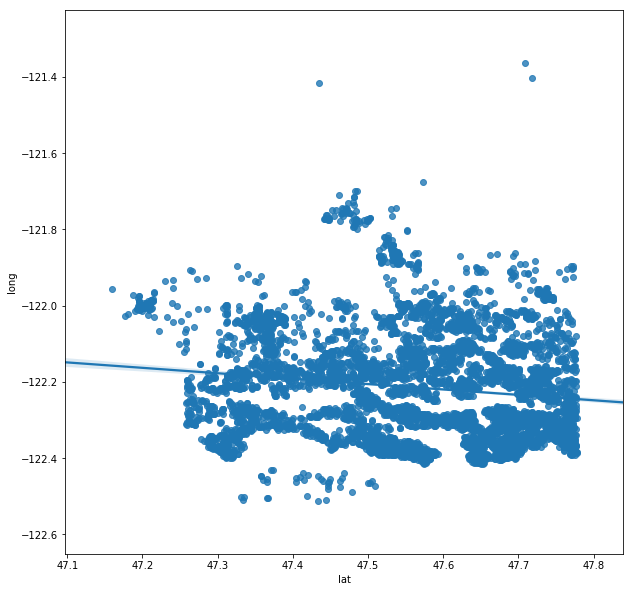

In [80]:
f, ax = plt.subplots(figsize=(10, 10))
fig = sns.regplot(x='lat', y="long", data=loc_data_test)

In [64]:
loc_data = pd.concat([h_loc['lat'], h_loc['long']], axis=1)

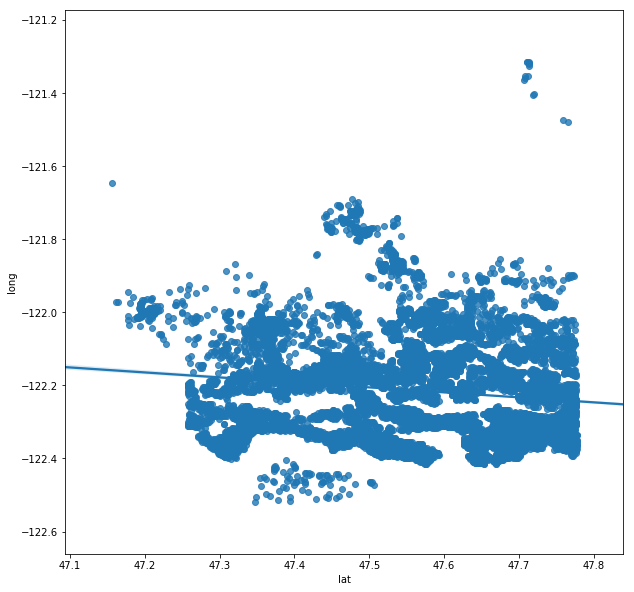

In [72]:
f, ax = plt.subplots(figsize=(10, 10))
fig = sns.regplot(x='lat', y="long", data=loc_data)

In [83]:
'''
id	price	lat	long
16413	0.068182	47.4347	-121.417      9
20098	0.020779	47.7093	-121.364  6
21446	0.041558	47.7179	-121.403     7
'''
h_loc[(h_loc['long']>-121.45) & (h_loc['long']<-121.35)]

,Newid,price,lat,long,grade
1853,121359.477076,0.017403,47.7076,-121.359,7
4298,121352.477087,0.019481,47.7087,-121.352,5
7067,121352.477120,0.025974,47.7120,-121.352,7
9748,121402.477200,0.048052,47.7200,-121.402,9
13668,121364.477074,0.020130,47.7074,-121.364,7
13900,121405.477185,0.053896,47.7185,-121.405,8


In [57]:
from sklearn.mixture import GaussianMixture

In [84]:
model = GaussianMixture(n_components =10, covariance_type = 'full')

In [85]:
model.fit(h_loc)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=10, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [86]:
y_h = model.predict(h_loc)

In [93]:
y_h_df = pd.DataFrame(columns=['lat_x_long'])

In [94]:
y_h_df['lat_x_long'] = y_h

In [96]:
y_h_df.head()

,lat_x_long
0,3
1,6
2,2
3,5
4,5


In [97]:
y_h_df.groupby('lat_x_long').size().reset_index(name="counts")

,lat_x_long,counts
0,0,364
1,1,2104
2,2,1587
3,3,1140
4,4,632
5,5,2148
6,6,3372
7,7,14
8,8,2555
9,9,1119


In [108]:
h_y_h_df = pd.concat([house, y_h_df], axis = 1)
h_y_h_df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,Newid,lat_x_long
0,2014.1013,0.028818,3,1.00,1180,5650,1.0,0,0,3,...,1180,0,1955,0,47.5112,-122.257,1340,5650,122257.475112,3
1,2015.0225,0.023377,2,1.00,770,10000,1.0,0,0,3,...,770,0,1933,0,47.7379,-122.233,2720,8062,122233.477379,6
2,2015.0218,0.066234,3,2.00,1680,8080,1.0,0,0,3,...,1680,0,1987,0,47.6168,-122.045,1800,7503,122045.476168,2
3,2014.0627,0.033442,3,2.25,1715,6819,2.0,0,0,3,...,1715,0,1995,0,47.3097,-122.327,2238,6819,122327.473097,5
4,2015.0115,0.037903,3,1.50,1060,9711,1.0,0,0,3,...,1060,0,1963,0,47.4095,-122.315,1650,9711,122315.474095,5


In [107]:
h_y_h_df[['Newid', 'lat', 'long', 'lat_x_long']].groupby('lat_x_long').aggregate('mean').drop(columns=['Newid'])

,lat,long
lat_x_long,,
0,47.371802,-122.257821
1,47.433622,-122.171964
2,47.461354,-122.030552
3,47.580287,-122.290980
4,47.577226,-121.871538
5,47.430047,-122.332251
6,47.679016,-122.169679
7,47.719550,-121.364143
8,47.672786,-122.358462


# 위치에따른 군집화하였으니 이거를 house data에 라벨링하기

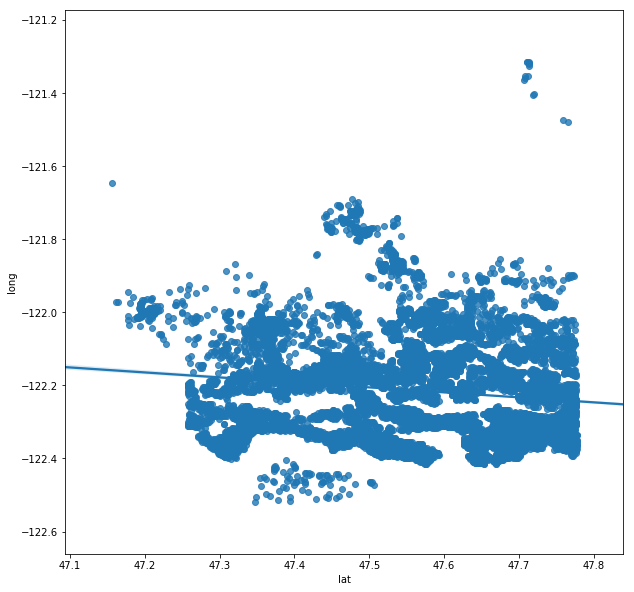

In [72]:
f, ax = plt.subplots(figsize=(10, 10))
fig = sns.regplot(x='lat', y="long", data=loc_data)

### \#. 재건축 여부
- 재건축한 것과 안한 것은 서로 분류해서 생각해야한다.

In [21]:
# 재건축한 것(house_re)과 안한 것(house_no)으로 나누기
house_no = house[house['yr_renovated']==0].reset_index(drop=True)
house_re = house[house['yr_renovated']!=0].reset_index(drop=True)

### \#. 15년 이전 면적 기준, 15년 이후 면적 기준
- 14년 구매엔 이전 것이 적용.
- 15년 구매시엔 15년 것이 적용. 아마도?
- 상관계수를 구해보자.
    - 14년도, 15년 초(몇월까지 ?)에 거래된 집의 가격과 15년 이전 기준 넓이의 상관계수
    - 15년 초 이후에 거래된 집의 가격과 15년 기준 넓이의 상관계수
- 15년 기준과 그 이전 기준 중 고르라고 하면 이전 기준으로 해야할 것 같다.
- 아무래도 부지 넓이랑 가격과는 상관이 없는 것 아닌가 싶다.

In [207]:
house[['id', 'price', 'date', 'sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_lot15', 'yr_renovated']].head()

,id,price,date,sqft_living,sqft_living15,sqft_lot,sqft_lot15,yr_renovated
0,0,0.028818,2014.1013,1180,1340,5650,5650,0
1,1,0.023377,2015.0225,770,2720,10000,8062,0
2,2,0.066234,2015.0218,1680,1800,8080,7503,0
3,3,0.033442,2014.0627,1715,2238,6819,6819,0
4,4,0.037903,2015.0115,1060,1650,9711,9711,0


In [226]:
# 2015이전과 이후로 데이터 구분
criteria = 2015
h_2014 = house[house['date']<criteria]  #2014년도 데이터
h_2015 = house[house['date']>=criteria] #2015년도 데이터

In [239]:
# 주거 공간 넓이랑 가격의 상관계수
h1 = [round(np.corrcoef(h_2014["price"], h_2014["sqft_living"])[0][1], 4), \
round(np.corrcoef(h_2014["price"], h_2014["sqft_living15"])[0][1], 4), \
round(np.corrcoef(h_2015["price"], h_2015["sqft_living"])[0][1], 4), \
round(np.corrcoef(h_2015["price"], h_2015["sqft_living15"])[0][1], 4)]    #상관계수 list ver.
h1_a = np.reshape(np.array(h1),(2,2))  # list to array
pd.DataFrame(h1_a, index=['price 2014', 'price 2015'], columns=["sqft_living", "sqft_living15"]) #DF로 만들기
# 2015 : (0.7149, 0.5851, 0.6772, 0.5899)
# 2015.02 : (0.7133, 0.5899, 0.6762, 0.578)
# 만약 15년 기준과 그 이전 기준 중 고르라고 하면 이전 기준으로 해야할 것 같다.

,sqft_living,sqft_living15
price 2014,0.7149,0.5851
price 2015,0.6772,0.5899


In [240]:
# 부지 넓이랑 가격의 상관계수
h2 = [round(np.corrcoef(h_2014["price"], h_2014["sqft_lot"])[0][1], 4), \
round(np.corrcoef(h_2014["price"], h_2014["sqft_lot15"])[0][1], 4), \
round(np.corrcoef(h_2015["price"], h_2015["sqft_lot"])[0][1], 4), \
round(np.corrcoef(h_2015["price"], h_2015["sqft_lot15"])[0][1], 4)]   #상관계수 list ver.
h2_a = np.reshape(np.array(h2),(2,2))   # list to array
pd.DataFrame(h2_a, index=['price 2014', 'price 2015'], columns=["sqft_lot", "sqft_lot15"]) #DF로 만들기
# (0.0899, 0.0815, 0.1106, 0.0961)
# 아무래도 부지 넓이랑 가격과는 상관이 없는 것 아닌가 싶다.

,sqft_lot,sqft_lot15
price 2014,0.0899,0.0815
price 2015,0.1106,0.0961


### \#. 가격정보

In [126]:
h_yr = house[['price', 'date', 'yr_built', 'yr_renovated']]
h_yr.tail()

,price,date,yr_built,yr_renovated
15030,0.079310,2014.1014,2014,0
15031,0.130844,2015.0326,2009,0
15032,0.046753,2014.0521,2009,0
15033,0.051948,2015.0223,2014,0
15034,0.042208,2014.1015,2008,0


In [128]:
h_yr_sort = h_yr.sort_values(by = ['yr_renovated', 'yr_built', 'date'],ascending=False).reset_index(drop=True)
h_yr_sort.head()

,price,date,yr_built,yr_renovated
0,0.107792,2015.0331,1968,2015
1,0.192857,2015.0506,1964,2015
2,0.105844,2015.0327,1962,2015
3,0.093117,2015.0406,1959,2015
4,0.113312,2015.0501,1956,2015
